# Import des librairies 
Chargement des librairies

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df=pd.read_csv('weatherAUS.csv')
df.head()
df['Date']=pd.to_datetime(df['Date'])

Enrichissment avec la quantité de pluie du lendemain

In [3]:
import sys

oldlocation=np.nan
raindayafter=np.nan
dateafter=np.nan
df['qtyraintomorrow']=np.nan

for idx in reversed(df.index):
    row=df.iloc[idx]
    datecurrent=row['Date']
    location=row['Location']  
    if (location==oldlocation)&(datecurrent + pd.DateOffset(days=1)==dateafter):
        df.loc[idx,'qtyraintomorrow']=raindayafter
    else:
        sys.stdout.write("x")
    raindayafter=row['Rainfall']
    oldlocation=location
    dateafter=datecurrent
    


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [4]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,qtyraintomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,0.0


# Enrichissement par calcul des variations
Les données sont enrichies par calcul de la variation d'u jour sur l'aure

In [5]:
import sys

oldlocation=np.nan
raindayafter=np.nan
datebefore=np.nan
df['varpressure']=np.nan
df['vartemp']=np.nan
df['varwind']=np.nan
df['varhumidity']=np.nan


for idx in df.index:
    row=df.iloc[idx]
    datecurrent=row['Date']
    pressurecurrent=row['Pressure3pm']
    tempcurrent=row['Temp3pm']
    windcurrent=row['WindGustSpeed']
    humiditycurrent=row['Humidity3pm']
    location=row['Location']  
    if (location==oldlocation)&(datecurrent + pd.DateOffset(days=-1)==datebefore):
        df.loc[idx,'varpressure']=pressurecurrent-pressurebefore
        df.loc[idx,'vartemp']=tempcurrent-tempbefore
        df.loc[idx,'varwind']=windcurrent-windbefore
        df.loc[idx,'varhumidity']=humiditycurrent-humiditybefore
    else:
        sys.stdout.write("x")
    pressurebefore=pressurecurrent
    tempbefore=tempcurrent
    windbefore=windcurrent
    humiditybefore=humiditycurrent
    oldlocation=location
    datebefore=datecurrent
    

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [6]:
df.to_csv('enricheredaus_sanscluster.csv')

In [12]:
df_augmente=pd.read_csv('enricheredaus_sanscluster.csv')
df_augmente.head()
df_augmente=df_augmente.iloc[:,-3:].join(df_augmente['RainTomorrow'])
df_augmente=df_augmente.dropna()

df_augmente.replace({'No': 0}, inplace=True)
df_augmente.replace({'Yes': 1}, inplace=True)
df_augmente.head()

,vartemp,varwind,varhumidity,RainTomorrow
1,2.5,0.0,3.0,0
2,-1.1,2.0,5.0,0
3,3.3,-22.0,-14.0,0
4,3.2,17.0,17.0,0
5,-0.8,15.0,-10.0,0


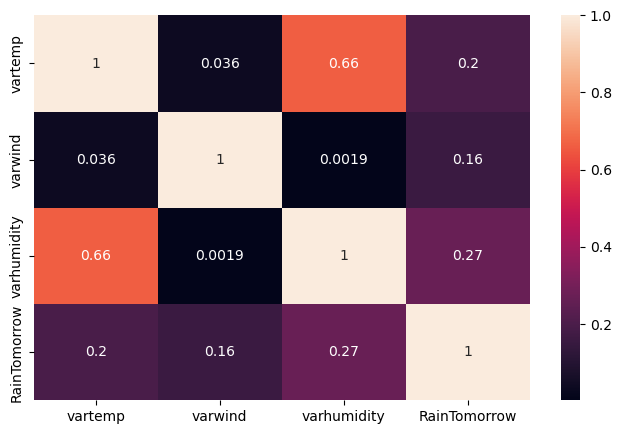

In [15]:

correlation=abs(df_augmente.corr())

plt.figure(figsize = (8,5))
sns.heatmap(correlation, annot=True)
plt.show()

